In [68]:
import pandas as pd
import matplotlib.pyplot as plt

In [69]:
#Importing data
sales = pd.read_csv('train.csv', index_col='id')

sales_shape = sales.shape # Variable to verify the number of rows in each preprocessing to avoid losing rows
print(sales.head(10))
print(sales_shape)

          date  store_nbr        family  sales  onpromotion
id                                                         
0   2013-01-01          1    AUTOMOTIVE    0.0            0
1   2013-01-01          1     BABY CARE    0.0            0
2   2013-01-01          1        BEAUTY    0.0            0
3   2013-01-01          1     BEVERAGES    0.0            0
4   2013-01-01          1         BOOKS    0.0            0
5   2013-01-01          1  BREAD/BAKERY    0.0            0
6   2013-01-01          1   CELEBRATION    0.0            0
7   2013-01-01          1      CLEANING    0.0            0
8   2013-01-01          1         DAIRY    0.0            0
9   2013-01-01          1          DELI    0.0            0
(3000888, 5)


# Exploring structure of the data

In [70]:
# Checking value dtypes per column
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date         object 
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 137.4+ MB


In [71]:
# Checking for null values in each column
sales.isnull().sum()

date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [72]:
# Checking minimum values and maximum values of numeric columns
sales.describe()

,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06
mean,2.750000e+01,3.577757e+02,2.602770e+00
std,1.558579e+01,1.101998e+03,1.221888e+01
min,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.400000e+01,0.000000e+00,0.000000e+00
50%,2.750000e+01,1.100000e+01,0.000000e+00
75%,4.100000e+01,1.958473e+02,0.000000e+00
max,5.400000e+01,1.247170e+05,7.410000e+02


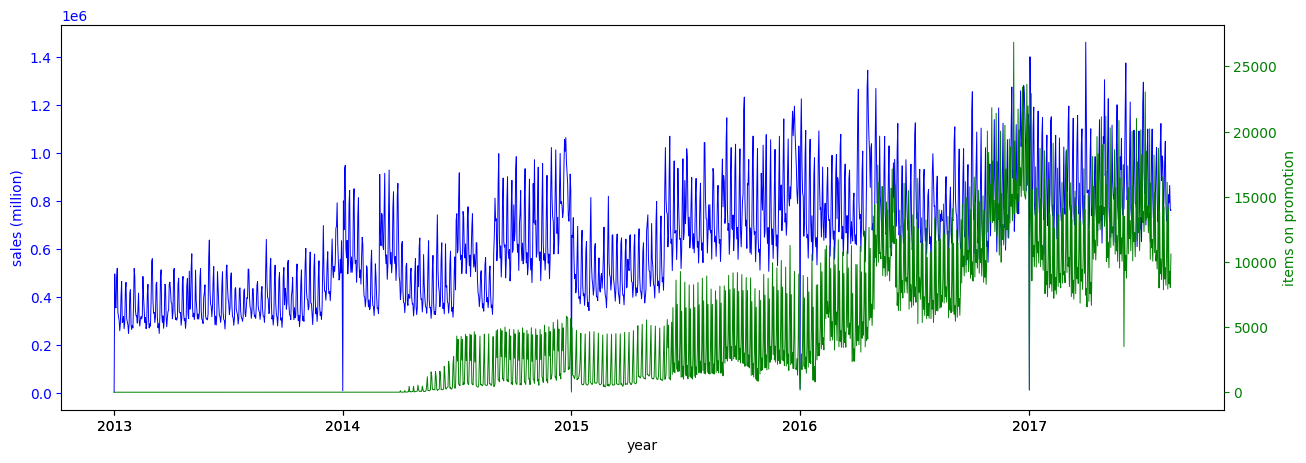

In [73]:
# Visualising sales and onpromotion values
sales_group = sales.groupby(['date']).sum()[['onpromotion','sales']]
sales_group.index = pd.to_datetime(sales_group.index)

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111,label = '1')
ax2 = fig.add_subplot(111, label = '2', frame_on = False)

ax.plot(sales_group['sales'], color = 'blue', linewidth = 0.7)
ax.set_xlabel('year')
ax.set_ylabel('sales (million)', color = 'blue')
ax.tick_params(axis = 'x')
ax.tick_params(axis = 'y', colors = 'blue')

ax2.plot(sales_group['onpromotion'], color = 'green', linewidth = 0.7)
ax2.yaxis.tick_right()
ax2.set_ylabel('items on promotion', color = 'green')
ax2.xaxis.set_label_position('top')
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis='y', colors = 'green')

plt.show()

### 'family' column

In [74]:
# Recoding the column with numerical value
def family_col_mod(df):
    temp = {f:i for i, f in enumerate(df.family.unique())}
    df.family = df.family.replace(temp)
    print(f'There are {len(df.family.unique())} product families, which are renumbered as following : \n')
    print(pd.DataFrame.from_dict(temp, orient = "index", columns = ["Product number"]))
    return df

In [75]:
sales = family_col_mod(sales)

There are 33 product families, which are renumbered as following : 

                            Product number
AUTOMOTIVE                               0
BABY CARE                                1
BEAUTY                                   2
BEVERAGES                                3
BOOKS                                    4
BREAD/BAKERY                             5
CELEBRATION                              6
CLEANING                                 7
DAIRY                                    8
DELI                                     9
EGGS                                    10
FROZEN FOODS                            11
GROCERY I                               12
GROCERY II                              13
HARDWARE                                14
HOME AND KITCHEN I                      15
HOME AND KITCHEN II                     16
HOME APPLIANCES                         17
HOME CARE                               18
LADIESWEAR                              19
LAWN AND GARDEN             

### 'date' column

In [76]:
# Reformatting 'date' column as datetime
sales.date = pd.to_datetime(sales.date)

# Creating a list of consecutive dates to compare for missing dates
temp = pd.date_range(start = min(sales.date).date(),
         end = max(sales.date).date(),
         freq = 'D')
missing = temp.difference(sales.date)
print(f'First record : {min(sales.date).date()}\n\
Last record : {max(sales.date).date()}\n\
Recorded days : {sales.date.nunique()}\n\
Unrecorded dates : {[t.strftime("%Y-%m-%d") for t in missing]}')

First record : 2013-01-01
Last record : 2017-08-15
Recorded days : 1684
Unrecorded dates : ['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25']


In [77]:
# Filling in the above missing dates with 0s, especially for traditional time series models
temp = pd.DataFrame(columns = sales.columns)
for i in missing:
    for j in range(1 ,sales.store_nbr.max()+1):
        for k in range(0, sales.family.max()+1):
            data = {'date':[i],
                    'store_nbr':[int(j)],
                    'family':[int(k)],
                    'sales':[float(0)],
                    'onpromotion':[int(0)]}
            temp = pd.concat([temp, pd.DataFrame.from_dict(data)])

sales = pd.concat([sales, temp])

sales = sales.sort_values(by = ['date','store_nbr','family']).reset_index()

# Assigning correct data type
sales['store_nbr'] = sales['store_nbr'].astype(int)
sales['family'] = sales['family'].astype(int)
sales['sales'] = sales['sales'].astype(float)
sales['onpromotion'] = sales['onpromotion'].astype(int)

# Making sure that rows are not missing
assert sales_shape[0]+4*54*33 == sales.shape[0] # original shape + (missing dates)*(stores)*(product family)

# Merging relevant information to the sales table

### Store-related characterictics

In [78]:
stores = pd.read_csv('stores.csv')
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [79]:
sales = sales.merge(stores, sort = False)
print(sales.shape)
sales.head()

(3008016, 10)


,index,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,0,0.0,0,Quito,Pichincha,D,13
1,1,2013-01-01,1,1,0.0,0,Quito,Pichincha,D,13
2,2,2013-01-01,1,2,0.0,0,Quito,Pichincha,D,13
3,3,2013-01-01,1,3,0.0,0,Quito,Pichincha,D,13
4,4,2013-01-01,1,4,0.0,0,Quito,Pichincha,D,13


### Holidays & Events

There are three types of respected holidays :
1) Holidays that are not transferred ('Holiday'&'False')
2) Transferred holidays ('Transferred'&'False')
3) Bridge ('Bridge' & 'False')
4) Additional ('Additional' & 'False')
WorkDays and Events are retained

In [80]:
holidays = pd.read_csv('holidays_events.csv')
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [9]:
# Composition of holiday types
holidays.groupby(['type','locale']).count()

date  locale_name  description  transferred
type       locale                                               
Additional Local       11           11           11           11
           National    40           40           40           40
Bridge     National     5            5            5            5
Event      National    56           56           56           56
Holiday    Local      137          137          137          137
           National    60           60           60           60
           Regional    24           24           24           24
Transfer   Local        4            4            4            4
           National     8            8            8            8
Work Day   National     5            5            5            5

There are local/regional/national holidays, which could impact sales differently especially depending on local and regional holidays. For simplicity, only national holidays are taken into account in the analysis. Dropping events as well. Perhaps to look into it later. 

In [10]:
holidays_national = holidays.loc[(holidays.locale == 'National') & (holidays.type != 'Event')]
holidays_national.head()

,date,type,locale,locale_name,description,transferred
14,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
21,2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
22,2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False


In [11]:
# Labelling national holidays based on whether it was actually respected or not
holidays_national['holiday'] = False # Workday
holidays_national.loc[(holidays.type == 'Holiday') & (holidays.transferred == False),'holiday'] = True # Holiday (Respected)
holidays_national.loc[(holidays.type == 'Transferred') | (holidays.type == 'Bridge')| (holidays.type == 'Additional'),'holiday'] = True # Holiday (Designated)

holidays_national

/tmp/ipykernel_448564/1877444734.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays_national['holiday'] = False # Workday


,date,type,locale,locale_name,description,transferred,holiday
14,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False,True
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True,False
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False,False
21,2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False,True
22,2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False,True
...,...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False,True
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False,True
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False,True
348,2017-12-25,Holiday,National,Ecuador,Navidad,False,True


In [12]:
# Checking to verify whether there are one holiday information per date
temp = holidays_national.groupby('date')['type'].count().sort_values()
temp_list = temp.loc[temp > 1]
for i in temp_list.index:
    print(holidays_national.loc[holidays_national['date'] == i])

          date        type    locale locale_name                description  \
39  2012-12-31      Bridge  National     Ecuador  Puente Primer dia del ano   
40  2012-12-31  Additional  National     Ecuador       Primer dia del ano-1   

    transferred  holiday  
39        False     True  
40        False     True  
          date        type    locale locale_name     description  transferred  \
35  2012-12-24      Bridge  National     Ecuador  Puente Navidad        False   
36  2012-12-24  Additional  National     Ecuador       Navidad-1        False   

    holiday  
35     True  
36     True  
           date        type    locale locale_name     description  \
156  2014-12-26      Bridge  National     Ecuador  Puente Navidad   
157  2014-12-26  Additional  National     Ecuador       Navidad+1   

     transferred  holiday  
156        False     True  
157        False     True  


In [13]:
# Dropping one of 2014-12-26 entry
holidays_national = holidays_national.drop(index=157)
holidays_national.date = pd.to_datetime(holidays_national.date)

In [14]:
def holiday_col_mod(df):
    df = df.merge(holidays_national[['date','holiday']], how = 'left', left_on = 'date', right_on = 'date')
    df['holiday'].fillna(False, inplace=True)
    return df


In [17]:
sales = holiday_col_mod(sales)
sales

,index,date,store_nbr,family,sales,onpromotion,holiday
0,0,2013-01-01,1,0,0.000,0,True
1,1,2013-01-01,1,1,0.000,0,True
2,2,2013-01-01,1,2,0.000,0,True
3,3,2013-01-01,1,3,0.000,0,True
4,4,2013-01-01,1,4,0.000,0,True
...,...,...,...,...,...,...,...
3007795,3000751,2017-08-15,54,28,59.619,0,False
3007796,3000752,2017-08-15,54,29,94.000,0,False
3007797,3000753,2017-08-15,54,30,915.371,76,False
3007798,3000754,2017-08-15,54,31,0.000,0,False


## Store 

## Oil price

In [20]:
oil = pd.read_csv('oil.csv')
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [21]:
oil['dcoilwtico'].isnull().sum()
# oil.shape

43

In [22]:
oil.date= pd.to_datetime(oil.date)
sales = sales.merge(oil, how = 'left')
sales.head()

,index,date,store_nbr,family,sales,onpromotion,holiday,type,cluster,dcoilwtico
0,0,2013-01-01,1,0,0.0,0,True,D,13,NaN
1,1,2013-01-01,1,1,0.0,0,True,D,13,NaN
2,2,2013-01-01,1,2,0.0,0,True,D,13,NaN
3,3,2013-01-01,1,3,0.0,0,True,D,13,NaN
4,4,2013-01-01,1,4,0.0,0,True,D,13,NaN


# Models

1. Univariate Time series models
- SARIMA

2. Traditional Time Series Model : Multivariate Time series models
- SARIMAX

3. Machine learning methods
- XGBoost : feature engineering (day of the week, seasonality)
- LSTM : scale  and format data 
- Facebook Prophet

Cross validation Scikit-Learn's TimeSeriesSplit 

# Reformatting test file

In [ ]:
test = pd.read_csv('test.csv')
test.date = pd.to_datetime(test.date)
test = family_col_mod(test) # Recategorizing family column
test = test.merge(stores[['store_nbr','type','cluster']], sort = False) # Adding store information
test = holiday_col_mod(test) # Adding holiday information
test = test.merge(oil, how = 'left') # Adding oil price information
test = test.set_index('id')

test.head()

## 1.Univariate, using Auto-Sarima

In [ ]:
from pmdarima.arima import auto_arima

pred_sarima = pd.DataFrame(columns = ['sales']).rename_axis('id')

for store in range(1,55): #55
    for family in range(0,33): # 33
        train_data = sales.loc[(sales['store_nbr'] == store) & (sales['family'] == family)].copy()
        train_data.index = train_data.date
        test_temp = test.loc[(test['store_nbr'] == store) & (test['family'] == family)].copy()

        y = train_data['sales']

        model = auto_arima(y,m = 7, seasonality = True, stepwise=False, n_jobs=-1, random = True, error_action = 'ignore', suppress_warnings=True,
                            method = 'bfgs')

        pred_sarima = pd.concat([pred_sarima,pd.DataFrame(model.predict(n_periods=16), columns = ['sales']).set_index(test_temp.index)])
    print(f'store{store} prediction finished')

pred_sarima

In [34]:
# Submission of result
pred_sarima.to_csv('submission_2.csv')

In [ ]:
# Multivariate, using auto_sarima
# with oppromotion and holiday

In [ ]:
from pmdarima.arima import auto_arima

pred_sarima = pd.DataFrame(columns = ['sales']).rename_axis('id')

for store in range(1,55): #55
    for family in range(0,33): # 33
        train_data = sales.loc[(sales['store_nbr'] == store) & (sales['family'] == family)].copy()
        train_data.index = train_data.date
        test_temp = test.loc[(test['store_nbr'] == store) & (test['family'] == family)].copy()

        X = train_data[['onpromotion','holiday']]
        y = train_data['sales']

        model = auto_arima(y=y, exogenous = X,
                           m = 7,
                           seasonality = True,
                           stepwise=False, n_jobs=-1, random = True,
                           error_action = 'ignore', suppress_warnings=True,
                           method = 'bfgs')

        pred_sarima = pd.concat([pred_sarima,pd.DataFrame(model.predict(
                                                                        n_periods=16,
                                                                        exogenous = test_temp[['onpromotion','holiday']]),
                                                          columns = ['sales']).set_index(test_temp.index)])
    print(f'store{store} prediction finished')

pred_sarima

In [47]:
pred_sarima.to_csv('submission_3.csv')

# Preprocessing for Machine Learning models with tabular data

In [24]:
# Lags
sales = sales.sort_values(by=['store_nbr','family','date'])
sales['sales_lag1'] = sales.groupby(['store_nbr','family'])['sales'].shift(1)
sales['sales_lag2'] = sales.groupby(['store_nbr','family'])['sales'].shift(2)
sales['sales_lag3'] = sales.groupby(['store_nbr','family'])['sales'].shift(3)
sales

,index,date,store_nbr,family,sales,onpromotion,holiday,type,cluster,dcoilwtico,sales_lag1,sales_lag2,sales_lag3
0,0,2013-01-01,1,0,0.0,0,True,D,13,NaN,NaN,NaN,NaN
33,1782,2013-01-02,1,0,2.0,0,False,D,13,93.14,0.0,NaN,NaN
66,3564,2013-01-03,1,0,3.0,0,False,D,13,92.97,2.0,0.0,NaN
99,5346,2013-01-04,1,0,3.0,0,False,D,13,93.12,3.0,2.0,0.0
132,7128,2013-01-05,1,0,5.0,0,False,D,13,NaN,3.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007667,2993627,2017-08-11,54,32,0.0,0,False,C,3,48.81,2.0,4.0,12.0
3007700,2995409,2017-08-12,54,32,1.0,1,False,C,3,NaN,0.0,2.0,4.0
3007733,2997191,2017-08-13,54,32,2.0,0,False,C,3,NaN,1.0,0.0,2.0
3007766,2998973,2017-08-14,54,32,0.0,0,False,C,3,47.59,2.0,1.0,0.0


In [17]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer
import calendar

# Turning dates into Trigonometric features
def date_encoding(df):

    # Day in a given year
    df['day_of_year'] = df['date'].dt.dayofyear
    year = df['date'].dt.year.apply(lambda x : 365 + calendar.isleap(x)) # Taking into account leap years
    df['sin_day_of_year'] = np.sin(2 * np.pi * df['day_of_year'] / year)
    df['cos_day_of_year'] = np.cos(2 * np.pi * df['day_of_year'] / year)

    # Day in a given month
    df['day_of_month'] = df['date'].dt.day
    df['days_in_month'] = df.apply(lambda row: calendar.monthrange(row['date'].year, row['date'].month)[1], axis = 1)
    df['sin_day_of_month'] = np.sin(2 * np.pi * df['day_of_month'] / df['days_in_month'])
    df['cos_day_of_month'] = np.cos(2 * np.pi * df['day_of_month'] / df['days_in_month'])

    # Day in a given week
    df['day_of_week'] = df['date'].dt.dayofweek
    df['sin_day_of_week'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['cos_day_of_week'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    df.drop(columns = ['day_of_year','day_of_week','day_of_month','days_in_month'], inplace = True)
    return df

In [26]:
sales = date_encoding(sales)
sales

,index,date,store_nbr,family,sales,onpromotion,holiday,type,cluster,dcoilwtico,sales_lag1,sales_lag2,sales_lag3,sin_day_of_year,cos_day_of_year,sin_day_of_month,cos_day_of_month,sin_day_of_week,cos_day_of_week
0,0,2013-01-01,1,0,0.0,0,True,D,13,NaN,NaN,NaN,NaN,0.017213,0.999852,0.201299,0.979530,0.781831,0.623490
33,1782,2013-01-02,1,0,2.0,0,False,D,13,93.14,0.0,NaN,NaN,0.034422,0.999407,0.394356,0.918958,0.974928,-0.222521
66,3564,2013-01-03,1,0,3.0,0,False,D,13,92.97,2.0,0.0,NaN,0.051620,0.998667,0.571268,0.820763,0.433884,-0.900969
99,5346,2013-01-04,1,0,3.0,0,False,D,13,93.12,3.0,2.0,0.0,0.068802,0.997630,0.724793,0.688967,-0.433884,-0.900969
132,7128,2013-01-05,1,0,5.0,0,False,D,13,NaN,3.0,3.0,2.0,0.085965,0.996298,0.848644,0.528964,-0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007667,2993627,2017-08-11,54,32,0.0,0,False,C,3,48.81,2.0,4.0,12.0,-0.642055,-0.766659,0.790776,-0.612106,-0.433884,-0.900969
3007700,2995409,2017-08-12,54,32,1.0,1,False,C,3,NaN,0.0,2.0,4.0,-0.655156,-0.755493,0.651372,-0.758758,-0.974928,-0.222521
3007733,2997191,2017-08-13,54,32,2.0,0,False,C,3,NaN,1.0,0.0,2.0,-0.668064,-0.744104,0.485302,-0.874347,-0.781831,0.623490
3007766,2998973,2017-08-14,54,32,0.0,0,False,C,3,47.59,2.0,1.0,0.0,-0.680773,-0.732494,0.299363,-0.954139,0.000000,1.000000


# One-hot-coding categorical variables

store_nbr
family
holiday : binary
type
cluster

In [18]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

def cat_encoding(df):
    encoder = OneHotEncoder(sparse_output = False, drop='if_binary')
    feature_names = ['store_nbr','family','type','cluster']
    encoded_array = encoder.fit_transform(df[feature_names])
    encoded_columns = pd.DataFrame(encoded_array, columns = encoder.get_feature_names_out(feature_names))
    print(encoder.get_feature_names_out(feature_names))
    df_with_encoded = pd.concat([df, encoded_columns], axis = 1)
    df_with_encoded = df_with_encoded.drop(columns = feature_names)

    return df_with_encoded

In [28]:
pd.options.display.max_columns = None
sales_with_encoded = cat_encoding(sales)
sales_with_encoded

['store_nbr_1' 'store_nbr_2' 'store_nbr_3' 'store_nbr_4' 'store_nbr_5'
 'store_nbr_6' 'store_nbr_7' 'store_nbr_8' 'store_nbr_9' 'store_nbr_10'
 'store_nbr_11' 'store_nbr_12' 'store_nbr_13' 'store_nbr_14'
 'store_nbr_15' 'store_nbr_16' 'store_nbr_17' 'store_nbr_18'
 'store_nbr_19' 'store_nbr_20' 'store_nbr_21' 'store_nbr_22'
 'store_nbr_23' 'store_nbr_24' 'store_nbr_25' 'store_nbr_26'
 'store_nbr_27' 'store_nbr_28' 'store_nbr_29' 'store_nbr_30'
 'store_nbr_31' 'store_nbr_32' 'store_nbr_33' 'store_nbr_34'
 'store_nbr_35' 'store_nbr_36' 'store_nbr_37' 'store_nbr_38'
 'store_nbr_39' 'store_nbr_40' 'store_nbr_41' 'store_nbr_42'
 'store_nbr_43' 'store_nbr_44' 'store_nbr_45' 'store_nbr_46'
 'store_nbr_47' 'store_nbr_48' 'store_nbr_49' 'store_nbr_50'
 'store_nbr_51' 'store_nbr_52' 'store_nbr_53' 'store_nbr_54' 'family_0'
 'family_1' 'family_2' 'family_3' 'family_4' 'family_5' 'family_6'
 'family_7' 'family_8' 'family_9' 'family_10' 'family_11' 'family_12'
 'family_13' 'family_14' 'family_15' '

,index,date,sales,onpromotion,holiday,dcoilwtico,sales_lag1,sales_lag2,sales_lag3,sin_day_of_year,cos_day_of_year,sin_day_of_month,cos_day_of_month,sin_day_of_week,cos_day_of_week,store_nbr_1,store_nbr_2,store_nbr_3,store_nbr_4,store_nbr_5,store_nbr_6,store_nbr_7,store_nbr_8,store_nbr_9,store_nbr_10,store_nbr_11,store_nbr_12,store_nbr_13,store_nbr_14,store_nbr_15,store_nbr_16,store_nbr_17,store_nbr_18,store_nbr_19,store_nbr_20,store_nbr_21,store_nbr_22,store_nbr_23,store_nbr_24,store_nbr_25,store_nbr_26,store_nbr_27,store_nbr_28,store_nbr_29,store_nbr_30,store_nbr_31,store_nbr_32,store_nbr_33,store_nbr_34,store_nbr_35,store_nbr_36,store_nbr_37,store_nbr_38,store_nbr_39,store_nbr_40,store_nbr_41,store_nbr_42,store_nbr_43,store_nbr_44,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,store_nbr_51,store_nbr_52,store_nbr_53,store_nbr_54,family_0,family_1,family_2,family_3,family_4,family_5,family_6,family_7,family_8,family_9,family_10,family_11,family_12,family_13,family_14,family_15,family_16,family_17,family_18,family_19,family_20,family_21,family_22,family_23,family_24,family_25,family_26,family_27,family_28,family_29,family_30,family_31,family_32,type_A,type_B,type_C,type_D,type_E,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17
0,0,2013-01-01,0.0,0,True,NaN,NaN,NaN,NaN,0.017213,0.999852,0.201299,0.979530,0.781831,0.623490,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
33,1782,2013-01-02,2.0,0,False,93.14,0.0,NaN,NaN,0.034422,0.999407,0.394356,0.918958,0.974928,-0.222521,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
66,3564,2013-01-03,3.0,0,False,92.97,2.0,0.0,NaN,0.051620,0.998667,0.571268,0.820763,0.433884,-0.900969,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
99,5346,2013-01-04,3.0,0,False,93.12,3.0,2.0,0.0,0.068802,0.997630,0.724793,0.688967,-0.433884,-0.900969,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
132,7128,2013-01-05,5.0,0,False,NaN,3.0,3.0,2.0,0.085965,0.996298,0.848644,0.528964,-0.974928,-0.222521,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [29]:
sales['dcoilwtico'].isnull().sum()/sales['dcoilwtico'].count()
# dropping dcoilwtico column as 45% of the values are null, and further dropping other columns that will not be used for training

0.45131452096198443

In [30]:
sales_with_encoded.drop(columns =['index','date'], inplace = True)
sales_with_encoded

,sales,onpromotion,holiday,dcoilwtico,sales_lag1,sales_lag2,sales_lag3,sin_day_of_year,cos_day_of_year,sin_day_of_month,cos_day_of_month,sin_day_of_week,cos_day_of_week,store_nbr_1,store_nbr_2,store_nbr_3,store_nbr_4,store_nbr_5,store_nbr_6,store_nbr_7,store_nbr_8,store_nbr_9,store_nbr_10,store_nbr_11,store_nbr_12,store_nbr_13,store_nbr_14,store_nbr_15,store_nbr_16,store_nbr_17,store_nbr_18,store_nbr_19,store_nbr_20,store_nbr_21,store_nbr_22,store_nbr_23,store_nbr_24,store_nbr_25,store_nbr_26,store_nbr_27,store_nbr_28,store_nbr_29,store_nbr_30,store_nbr_31,store_nbr_32,store_nbr_33,store_nbr_34,store_nbr_35,store_nbr_36,store_nbr_37,store_nbr_38,store_nbr_39,store_nbr_40,store_nbr_41,store_nbr_42,store_nbr_43,store_nbr_44,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,store_nbr_51,store_nbr_52,store_nbr_53,store_nbr_54,family_0,family_1,family_2,family_3,family_4,family_5,family_6,family_7,family_8,family_9,family_10,family_11,family_12,family_13,family_14,family_15,family_16,family_17,family_18,family_19,family_20,family_21,family_22,family_23,family_24,family_25,family_26,family_27,family_28,family_29,family_30,family_31,family_32,type_A,type_B,type_C,type_D,type_E,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17
0,0.0,0,True,NaN,NaN,NaN,NaN,0.017213,0.999852,0.201299,0.979530,0.781831,0.623490,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
33,2.0,0,False,93.14,0.0,NaN,NaN,0.034422,0.999407,0.394356,0.918958,0.974928,-0.222521,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
66,3.0,0,False,92.97,2.0,0.0,NaN,0.051620,0.998667,0.571268,0.820763,0.433884,-0.900969,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
99,3.0,0,False,93.12,3.0,2.0,0.0,0.068802,0.997630,0.724793,0.688967,-0.433884,-0.900969,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
132,5.0,0,False,NaN,3.0,3.0,2.0,0.085965,0.996298,0.848644,0.528964,-0.974928,-0.222521,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0

In [31]:
sales_with_encoded = sales_with_encoded.drop(columns = 'dcoilwtico')

In [32]:
sales_with_encoded = sales_with_encoded.dropna()

In [33]:
sales_with_encoded

,sales,onpromotion,holiday,sales_lag1,sales_lag2,sales_lag3,sin_day_of_year,cos_day_of_year,sin_day_of_month,cos_day_of_month,sin_day_of_week,cos_day_of_week,store_nbr_1,store_nbr_2,store_nbr_3,store_nbr_4,store_nbr_5,store_nbr_6,store_nbr_7,store_nbr_8,store_nbr_9,store_nbr_10,store_nbr_11,store_nbr_12,store_nbr_13,store_nbr_14,store_nbr_15,store_nbr_16,store_nbr_17,store_nbr_18,store_nbr_19,store_nbr_20,store_nbr_21,store_nbr_22,store_nbr_23,store_nbr_24,store_nbr_25,store_nbr_26,store_nbr_27,store_nbr_28,store_nbr_29,store_nbr_30,store_nbr_31,store_nbr_32,store_nbr_33,store_nbr_34,store_nbr_35,store_nbr_36,store_nbr_37,store_nbr_38,store_nbr_39,store_nbr_40,store_nbr_41,store_nbr_42,store_nbr_43,store_nbr_44,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,store_nbr_51,store_nbr_52,store_nbr_53,store_nbr_54,family_0,family_1,family_2,family_3,family_4,family_5,family_6,family_7,family_8,family_9,family_10,family_11,family_12,family_13,family_14,family_15,family_16,family_17,family_18,family_19,family_20,family_21,family_22,family_23,family_24,family_25,family_26,family_27,family_28,family_29,family_30,family_31,family_32,type_A,type_B,type_C,type_D,type_E,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17
99,3.0,0,False,3.0,2.0,0.0,0.068802,0.997630,0.724793,0.688967,-0.433884,-0.900969,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
132,5.0,0,False,3.0,3.0,2.0,0.085965,0.996298,0.848644,0.528964,-0.974928,-0.222521,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
165,2.0,0,False,5.0,3.0,3.0,0.103102,0.994671,0.937752,0.347305,-0.781831,0.623490,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
198,0.0,0,False,2.0,5.0,3.0,0.120208,0.992749,0.988468,0.151428,0.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
231,2.0,0,False,0.0,2.0,5.0,0.137279,0.990532,0.998717,-0.050649,0.781831,0.623490,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,.

In [34]:
sales_with_encoded.to_csv('cleaned_train.csv', index_label = 'id')

In [1]:
#Saving and reloading the prepared data as the kernel keeps crashing
del sales_with_encoded

NameError: name 'sales_with_encoded' is not defined

In [2]:
import pandas as pd
pd.options.display.max_columns = None

sales_loaded = pd.read_csv('cleaned_train.csv', index_col='id',dtype = float)
sales_loaded

,sales,onpromotion,holiday,sales_lag1,sales_lag2,sales_lag3,sin_day_of_year,cos_day_of_year,sin_day_of_month,cos_day_of_month,sin_day_of_week,cos_day_of_week,store_nbr_1,store_nbr_2,store_nbr_3,store_nbr_4,store_nbr_5,store_nbr_6,store_nbr_7,store_nbr_8,store_nbr_9,store_nbr_10,store_nbr_11,store_nbr_12,store_nbr_13,store_nbr_14,store_nbr_15,store_nbr_16,store_nbr_17,store_nbr_18,store_nbr_19,store_nbr_20,store_nbr_21,store_nbr_22,store_nbr_23,store_nbr_24,store_nbr_25,store_nbr_26,store_nbr_27,store_nbr_28,store_nbr_29,store_nbr_30,store_nbr_31,store_nbr_32,store_nbr_33,store_nbr_34,store_nbr_35,store_nbr_36,store_nbr_37,store_nbr_38,store_nbr_39,store_nbr_40,store_nbr_41,store_nbr_42,store_nbr_43,store_nbr_44,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,store_nbr_51,store_nbr_52,store_nbr_53,store_nbr_54,family_0,family_1,family_2,family_3,family_4,family_5,family_6,family_7,family_8,family_9,family_10,family_11,family_12,family_13,family_14,family_15,family_16,family_17,family_18,family_19,family_20,family_21,family_22,family_23,family_24,family_25,family_26,family_27,family_28,family_29,family_30,family_31,family_32,type_A,type_B,type_C,type_D,type_E,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
99.0,3.0,0.0,0.0,3.0,2.0,0.0,0.068802,0.997630,0.724793,0.688967,-0.433884,-0.900969,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
132.0,5.0,0.0,0.0,3.0,3.0,2.0,0.085965,0.996298,0.848644,0.528964,-0.974928,-0.222521,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
165.0,2.0,0.0,0.0,5.0,3.0,3.0,0.103102,0.994671,0.937752,0.347305,-0.781831,0.623490,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
198.0,0.0,0.0,0.0,2.0,5.0,3.0,0.120208,0.992749,0.988468,0.151428,0.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
231.0,2.0,0.0,0.0,0.0,2.0,5.0,0.137279,0.990532,0.998717,-0.050649,0.781831,0.623490,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [3]:
# Ensemble Regressors / SVR(kernel='rbf') / RIdgeRegression / SVR(kernel-'linear)

from sklearn.ensemble import HistGradientBoostingRegressor
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

X = sales_loaded.drop(columns = 'sales')
y = sales_loaded['sales']

tscv = TimeSeriesSplit(n_splits=5, test_size=16)

model = HistGradientBoostingRegressor()

score = cross_val_score(model, X=X, y=y, cv = tscv, scoring = 'neg_mean_squared_error')

-score

array([26.45125574, 27.91067518, 28.30338296, 21.41228956, 18.21371759])

In [4]:
model = model.fit(X,y)

In [19]:
test = pd.read_csv('test.csv', index_col='id')
test_index = test.index
test['date'] = pd.to_datetime(test['date'])

#holiday
test = holiday_col_mod(test)

# Adding lags as placeholder
test['sales_lag1'] = np.nan
test['sales_lag2'] = np.nan
test['sales_lag3'] = np.nan

#family
test = family_col_mod(test)

#store
test = test.merge(stores[['store_nbr','type','cluster']], sort = False)


#date encoding
test = date_encoding(test)
#categorical encoding
test = cat_encoding(test)

test.index = test_index
test

There are 33 product families, which are renumbered as following : 
                                Product number
AUTOMOTIVE                               0
BABY CARE                                1
BEAUTY                                   2
BEVERAGES                                3
BOOKS                                    4
BREAD/BAKERY                             5
CELEBRATION                              6
CLEANING                                 7
DAIRY                                    8
DELI                                     9
EGGS                                    10
FROZEN FOODS                            11
GROCERY I                               12
GROCERY II                              13
HARDWARE                                14
HOME AND KITCHEN I                      15
HOME AND KITCHEN II                     16
HOME APPLIANCES                         17
HOME CARE                               18
LADIESWEAR                              19
LAWN AND GARDEN          

,date,onpromotion,holiday,sales_lag1,sales_lag2,sales_lag3,sin_day_of_year,cos_day_of_year,sin_day_of_month,cos_day_of_month,sin_day_of_week,cos_day_of_week,store_nbr_1,store_nbr_2,store_nbr_3,store_nbr_4,store_nbr_5,store_nbr_6,store_nbr_7,store_nbr_8,store_nbr_9,store_nbr_10,store_nbr_11,store_nbr_12,store_nbr_13,store_nbr_14,store_nbr_15,store_nbr_16,store_nbr_17,store_nbr_18,store_nbr_19,store_nbr_20,store_nbr_21,store_nbr_22,store_nbr_23,store_nbr_24,store_nbr_25,store_nbr_26,store_nbr_27,store_nbr_28,store_nbr_29,store_nbr_30,store_nbr_31,store_nbr_32,store_nbr_33,store_nbr_34,store_nbr_35,store_nbr_36,store_nbr_37,store_nbr_38,store_nbr_39,store_nbr_40,store_nbr_41,store_nbr_42,store_nbr_43,store_nbr_44,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,store_nbr_51,store_nbr_52,store_nbr_53,store_nbr_54,family_0,family_1,family_2,family_3,family_4,family_5,family_6,family_7,family_8,family_9,family_10,family_11,family_12,family_13,family_14,family_15,family_16,family_17,family_18,family_19,family_20,family_21,family_22,family_23,family_24,family_25,family_26,family_27,family_28,family_29,family_30,family_31,family_32,type_A,type_B,type_C,type_D,type_E,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3000888,2017-08-16,0,False,NaN,NaN,NaN,-0.705584,-0.708627,-1.011683e-01,-0.994869,0.974928,-0.222521,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3000889,2017-08-16,0,False,NaN,NaN,NaN,-0.705584,-0.708627,-1.011683e-01,-0.994869,0.974928,-0.222521,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3000890,2017-08-16,2,False,NaN,NaN,NaN,-0.705584,-0.708627,-1.011683e-01,-0.994869,0.974928,-0.222521,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3000891,2017-08-16,20,False,NaN,NaN,NaN,-0.705584,-0.708627,-1.011683e-01,-0.994869,0.974928,-0.222521,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3000892,2017-08-16,0,False,NaN,NaN,NaN,-0.705584,-0.708627,-1.011683e-01,-0.994869,0.974928,-0.222521,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.

In [48]:
pd.options.display.max_columns = None
test


,date,onpromotion,holiday,sales_lag1,sales_lag2,sales_lag3,sin_day_of_year,cos_day_of_year,sin_day_of_month,cos_day_of_month,sin_day_of_week,cos_day_of_week,store_nbr_1,store_nbr_2,store_nbr_3,store_nbr_4,store_nbr_5,store_nbr_6,store_nbr_7,store_nbr_8,store_nbr_9,store_nbr_10,store_nbr_11,store_nbr_12,store_nbr_13,store_nbr_14,store_nbr_15,store_nbr_16,store_nbr_17,store_nbr_18,store_nbr_19,store_nbr_20,store_nbr_21,store_nbr_22,store_nbr_23,store_nbr_24,store_nbr_25,store_nbr_26,store_nbr_27,store_nbr_28,store_nbr_29,store_nbr_30,store_nbr_31,store_nbr_32,store_nbr_33,store_nbr_34,store_nbr_35,store_nbr_36,store_nbr_37,store_nbr_38,store_nbr_39,store_nbr_40,store_nbr_41,store_nbr_42,store_nbr_43,store_nbr_44,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,store_nbr_51,store_nbr_52,store_nbr_53,store_nbr_54,family_0,family_1,family_2,family_3,family_4,family_5,family_6,family_7,family_8,family_9,family_10,family_11,family_12,family_13,family_14,family_15,family_16,family_17,family_18,family_19,family_20,family_21,family_22,family_23,family_24,family_25,family_26,family_27,family_28,family_29,family_30,family_31,family_32,type_A,type_B,type_C,type_D,type_E,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3000888,2017-08-16,0,False,NaN,NaN,NaN,-0.705584,-0.708627,-1.011683e-01,-0.994869,0.974928,-0.222521,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3000889,2017-08-16,0,False,NaN,NaN,NaN,-0.705584,-0.708627,-1.011683e-01,-0.994869,0.974928,-0.222521,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3000890,2017-08-16,2,False,NaN,NaN,NaN,-0.705584,-0.708627,-1.011683e-01,-0.994869,0.974928,-0.222521,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3000891,2017-08-16,20,False,NaN,NaN,NaN,-0.705584,-0.708627,-1.011683e-01,-0.994869,0.974928,-0.222521,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3000892,2017-08-16,0,False,NaN,NaN,NaN,-0.705584,-0.708627,-1.011683e-01,-0.994869,0.974928,-0.222521,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.

In [21]:
#Window rolling method
from datetime import datetime, timedelta

test_lagged = test.copy()

test_lagged['sales'] = 0

for store in range(1,55):
    for product in range(0,33):
        # Retrieving the last row of the training data
        last_train_row = sales_loaded[(sales_loaded['family_'+str(product)] == 1) & (sales_loaded['store_nbr_'+str(store)] == 1)].iloc[-1]
        #Assigning the last row of the training data to the first row of the test data
        first_date_filter = (test_lagged['date'] == '2017-08-16')
        product_filter = (test_lagged['family_'+str(product)] == 1)
        store_filter  = (test_lagged['store_nbr_'+str(store)] == 1)
        test_lagged.loc[first_date_filter & product_filter & store_filter, 'sales_lag1'] = last_train_row['sales']
        test_lagged.loc[first_date_filter & product_filter & store_filter, 'sales_lag2'] = last_train_row['sales_lag1']
        test_lagged.loc[first_date_filter & product_filter & store_filter, 'sales_lag3'] = last_train_row['sales_lag2']

        for day in test_lagged.date.unique()[1:]: # Starting for loop from second day (8-16) to last day (8-31)
            #Prediction from previous date and assigning the predicted value to the date
            day_before_filter = (test_lagged['date'] == pd.to_datetime(day)-timedelta(days=1))
            row = test_lagged.loc[store_filter & product_filter & day_before_filter].drop(columns = ['date','sales'])
            pred_value = model.predict(row)
            test_lagged.loc[store_filter & product_filter & day_before_filter,'sales'] = pred_value
            # Assigning lag values from the day before
            test_lagged.loc[store_filter & product_filter & (test_lagged['date'] == day), 'sales_lag1'] = pred_value
            test_lagged.loc[store_filter & product_filter & (test_lagged['date'] == day), 'sales_lag2'] = test_lagged.loc[store_filter & product_filter & day_before_filter, 'sales_lag1'].iloc[0]
            test_lagged.loc[store_filter & product_filter & (test_lagged['date'] == day), 'sales_lag3'] = test_lagged.loc[store_filter & product_filter & day_before_filter, 'sales_lag2'].iloc[0]

        # Prediction for the last day (8-31)
        last_date_filter = (test_lagged['date'] ==test_lagged.date.unique()[-1])
        row = test_lagged.loc[store_filter & product_filter & last_date_filter].drop(columns = ['date','sales'])
        pred_value = model.predict(row)
        test_lagged.loc[store_filter & product_filter & last_date_filter,'sales'] = pred_value
test_lagged

,date,onpromotion,holiday,sales_lag1,sales_lag2,sales_lag3,sin_day_of_year,cos_day_of_year,sin_day_of_month,cos_day_of_month,sin_day_of_week,cos_day_of_week,store_nbr_1,store_nbr_2,store_nbr_3,store_nbr_4,store_nbr_5,store_nbr_6,store_nbr_7,store_nbr_8,store_nbr_9,store_nbr_10,store_nbr_11,store_nbr_12,store_nbr_13,store_nbr_14,store_nbr_15,store_nbr_16,store_nbr_17,store_nbr_18,store_nbr_19,store_nbr_20,store_nbr_21,store_nbr_22,store_nbr_23,store_nbr_24,store_nbr_25,store_nbr_26,store_nbr_27,store_nbr_28,store_nbr_29,store_nbr_30,store_nbr_31,store_nbr_32,store_nbr_33,store_nbr_34,store_nbr_35,store_nbr_36,store_nbr_37,store_nbr_38,store_nbr_39,store_nbr_40,store_nbr_41,store_nbr_42,store_nbr_43,store_nbr_44,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,store_nbr_51,store_nbr_52,store_nbr_53,store_nbr_54,family_0,family_1,family_2,family_3,family_4,family_5,family_6,family_7,family_8,family_9,family_10,family_11,family_12,family_13,family_14,family_15,family_16,family_17,family_18,family_19,family_20,family_21,family_22,family_23,family_24,family_25,family_26,family_27,family_28,family_29,family_30,family_31,family_32,type_A,type_B,type_C,type_D,type_E,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,sales
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3000888,2017-08-16,0,False,31.452000,26.345000,21.654000,-0.705584,-0.708627,-1.011683e-01,-0.994869,0.974928,-0.222521,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,27.851038
3000889,2017-08-16,0,False,27.314000,22.232000,37.282000,-0.705584,-0.708627,-1.011683e-01,-0.994869,0.974928,-0.222521,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,20.442099
3000890,2017-08-16,2,False,3.934000,26.504000,34.818000,-0.705584,-0.708627,-1.011683e-01,-0.994869,0.974928,-0.222521,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,29.206694
3000891,2017-08-16,20,False,27.285000,7.826000,7.489000,-0.705584,-0.708627,-1.011683e-01,-0.994869,0.974928,-0.222521,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,125.891280
3000892,2017-08-16,0,False,19.346000,24.367000,27.061000,-0.705584,-0.708627,-1.011683e-01,-0.994869,0.974928,-0.222521,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [22]:
test_lagged.loc[(test_lagged['store_nbr_1'] == 1) & (test_lagged['family_0'] == 1)].sort_values(by='date')

,date,onpromotion,holiday,sales_lag1,sales_lag2,sales_lag3,sin_day_of_year,cos_day_of_year,sin_day_of_month,cos_day_of_month,sin_day_of_week,cos_day_of_week,store_nbr_1,store_nbr_2,store_nbr_3,store_nbr_4,store_nbr_5,store_nbr_6,store_nbr_7,store_nbr_8,store_nbr_9,store_nbr_10,store_nbr_11,store_nbr_12,store_nbr_13,store_nbr_14,store_nbr_15,store_nbr_16,store_nbr_17,store_nbr_18,store_nbr_19,store_nbr_20,store_nbr_21,store_nbr_22,store_nbr_23,store_nbr_24,store_nbr_25,store_nbr_26,store_nbr_27,store_nbr_28,store_nbr_29,store_nbr_30,store_nbr_31,store_nbr_32,store_nbr_33,store_nbr_34,store_nbr_35,store_nbr_36,store_nbr_37,store_nbr_38,store_nbr_39,store_nbr_40,store_nbr_41,store_nbr_42,store_nbr_43,store_nbr_44,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,store_nbr_51,store_nbr_52,store_nbr_53,store_nbr_54,family_0,family_1,family_2,family_3,family_4,family_5,family_6,family_7,family_8,family_9,family_10,family_11,family_12,family_13,family_14,family_15,family_16,family_17,family_18,family_19,family_20,family_21,family_22,family_23,family_24,family_25,family_26,family_27,family_28,family_29,family_30,family_31,family_32,type_A,type_B,type_C,type_D,type_E,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,sales
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3000888,2017-08-16,0,False,31.452000,26.345000,21.654000,-0.705584,-0.708627,-1.011683e-01,-0.994869,0.974928,-0.222521,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,27.851038
3000921,2017-08-17,0,False,27.851038,31.452000,26.345000,-0.717677,-0.696376,-2.993631e-01,-0.954139,0.433884,-0.900969,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,21.406112
3000954,2017-08-18,0,False,21.406112,27.851038,31.452000,-0.729558,-0.683919,-4.853020e-01,-0.874347,-0.433884,-0.900969,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,18.254327
3000987,2017-08-19,0,False,18.254327,21.406112,27.851038,-0.741222,-0.671260,-6.513725e-01,-0.758758,-0.974928,-0.222521,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,21.694173
3001020,2017-08-20,0,False,21.694173,18.254327,21.406112,-0.752667,-0.658402,-7.907757e-01,-0.612106,-0.781831,0.623490,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [25]:
result = test_lagged['sales']
result

id
3000888      27.851038
3000889      20.442099
3000890      29.206694
3000891     125.891280
3000892      17.834459
              ...     
3029395      89.691688
3029396       9.491961
3029397    1613.749333
3029398     179.619416
3029399       9.800913
Name: sales, Length: 28512, dtype: float64

In [26]:
result.to_csv('submission_5.csv')